# Neural network models

This notebook picks up after the `simple_models` notebook. After trying a range of classification algorithms, we'll try out some of the neural network models in [1]. These include fully-connected models of varying layer sizes, and finally convolutional models including the famous LeNet-5. 

Along the way, we'll be using Keras which is a library sitting on top of Theano or Tensorflow. This allows easy construction, training and evaluation of neural nets. Before we get started, here's a recap of the `simple_models` notebook models.

`[1]` - [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf),  LeCun et al, Nov 1998

In [1]:
# Load in dependencies, may not use all of these
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

%matplotlib inline

## Load pickle files

The original data files are processed using the `convert_data.py` script, and written out to pickle files. We can load these in as numpy arrays.

In [133]:
# Set up the file directory and names
DIR = '../input/'
X_TRAIN = DIR + 'train-images-idx3-ubyte.pkl'
Y_TRAIN = DIR + 'train-labels-idx1-ubyte.pkl'
X_TEST = DIR + 't10k-images-idx3-ubyte.pkl'
Y_TEST = DIR + 't10k-labels-idx1-ubyte.pkl'

def load_data():
    '''Loads pickled ubyte files with MNIST data
    INPUT: X_train_file, y_train_file - strings with training filenames
           X_test_file, y_test_File - strings with test filenames
    RETURNS: Tuple with (X_train, y_train, X_test, y_test)
    '''
    print('Loading pickle files ...')
    try:
        X_train = pickle.load( open( X_TRAIN, "rb" ) )
        y_train = pickle.load( open( Y_TRAIN, "rb" ) )
        X_test = pickle.load( open( X_TEST, "rb" ) )
        y_test = pickle.load( open( Y_TEST, "rb" ) )
    except:
        print('Error loading pickle file')
        return None
        
    return (X_train, y_train, X_test, y_test)

X_train, y_train, X_test,  y_test = load_data()

Loading pickle files ...


## Helper functions

Before evaluating some models on the images, let's create some helper functions we can re-use later on. These deal with converting images to and from 1d and 2d versions, plotting images, resizing them, etc.

In [134]:
def flatten_images(X):
    ''' Converts images to 1-d vectors
    INPUT: X - Input array of shape [n, w, h]
    RETURNS: Numpy array of shape [n, w*h]
    '''
    n, w, h = X.shape
    X_flat = X.reshape((n, w * h))
    return X_flat

def square_images(X, w=None, h=None):
    '''Converts single-vector images into square images 
    INPUT: X - numpy array of images in single-vector form
           w - width of images to convert to
           h - height of images to convert to
    RETURNS: Numpy array of shape [n, w, h]
    '''
    
    assert X.shape[1] == w * h, "Error - Can't square array of shape {} to {}".format(X.shape, (w, h))
    n = X.shape[0]
    X_square = X.reshape((n, w, h))
    return X_square


N_TRAIN, W, H = X_train.shape
N_TEST, w_test, h_test = X_test.shape

# Flatten the images
X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

# Do some checks on the data
assert N_TRAIN == 60000, 'Error - expected 60000 training images, got {}'.format(N_TRAIN)
assert N_TEST == 10000, 'Error - expected 60000 training images, got {}'.format(N_TEST)
assert W == w_test, 'Error - width mismatch. Train {}, Test {}'.format(w, w_test)
assert H == h_test, 'Error - height mismatch. Train {}, Test {}'.format(h, h_test)

assert np.array_equal(X_train, flatten_images(square_images(X_train, W, H)))
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print('Loaded train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Loaded test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))


Loaded train images shape (60000, 784), labels shape (60000, 1)
Loaded test images shape (10000, 784), labels shape (10000, 1)


## Data preparation

This section sets up global constants used in all models (to ensure a fair comparison). It also prepares the data by converting y values to one-hot, and normalizing X inputs.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Keras Common configuration
SEED = 1234 # Fix the seed for repeatability
N_JOBS=-2 # Leave 1 core free for UI updates
VERBOSE=2 # 3 is the most verbose level
NB_EPOCH = 20 # todo ! Check how many epochs in the paper
BATCH = 256 # todo ! Check this in the paper too


def stratified_subsample(X, y, num_rows):
    '''Creates a stratified subsample of X and y
    INPUT: X and y, numpy arrays
    RETURNS: subset of X and y, maintaining class balances
    '''
    # Create a stratified, shuffled subset of the training data if needed
    N = X.shape[0]
    if num_rows < N:
        print('Reducing size from {} to {} examples'.format(N, num_rows))
        new_X, _, new_y, _ = train_test_split(X_train, y_train, 
                                              train_size=N, random_state=SEED)    

def onehot_encode_y(y_train, y_test):
    '''Convert y_train and y_test to a one-hot encoding version
    INPUT: y_train - np.array of size (n_train,)
           y_test - np.array of size (n_test,)
    RETURNS: y_train - np.array of size (n_train, n_classes)
             y_test - np.arary of size (n_test, n_classes)
    '''    
    print('Converting y variables to one-hot encoding..')
    lbe = LabelBinarizer()
    lbe.fit(y_train)
    y_train = lbe.transform(y_train)
    y_test = lbe.transform(y_test)
    return y_train, y_test

def z_norm_X(X_train, X_test):
    '''Z-normalizes X_train and X_test with 0 mean and 1 std. dev.
    INPUT: X_train - training set
           X_test - test set
    RETURNS: X_train - normalized version of same size
             X_test - normalized version (using X_train parameters)
    '''
    print('Z-normalizing X data..')    
    std = StandardScaler()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    std.fit(X_train)
    X_train = std.transform(X_train)
    X_test = std.transform(X_test)
    return X_train, X_test
    
y_train, y_test = onehot_encode_y(y_train, y_test)
X_train, X_test = z_norm_X(X_train, X_test)
scores = dict()

print('Train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Converting y variables to one-hot encoding..
Z-normalizing X data..
Train images shape (60000, 784), labels shape (60000, 10)
Test images shape (10000, 784), labels shape (10000, 10)


## [1] C.5 - Baseline fully-connected models (original dataset)

We'll first compare the performance of different fully-connected models on fully-connected networks of varying layers and size. These are all trained on the 28x28 dataset.

## Helper class

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Create a dictionary to store model training and test info
models = dict()

class KerasFCModel(object):
    
    def __init__(self, model_name, model_type, input_dim, layers, 
                 activation, output_activation, verbose=None):
        '''Initializes a new keras model'''
        self.model_name = model_name
        self.verbose = verbose
        
        model = model_type
        for idx, size in enumerate(layers):
            if idx == 0:
                if self.verbose == 2:
                    print('Adding input dense layer, input dim {}, dim {}'.format(input_dim, size))
                model.add(Dense(size, input_dim=input_dim))
                model.add(Activation(activation))
            elif idx == len(layers) - 1:
                if self.verbose == 2:
                    print('Adding dense layer {}, size {}, activation {}'.format(idx, size, activation))
                model.add(Dense(size))
                model.add(Activation(activation))
            else:
                if self.verbose == 2:
                    print('Adding output layer {}, size {}, activation {}'.format(idx, size, output_activation))
                model.add(Dense(size))
                model.add(Activation(output_activation))
                
        if self.verbose == 1:
            print('Model summary:\n')
            model.summary()
        
        self.model = model

    def compile(self, loss, optimizer, metrics):
        '''Compile the model'''
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        # Need to flip error vs accuracy 
        metrics = ['acc' if metric is 'error' else metric for metric in metrics]
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
          
    def fit(self, X, y, nb_epoch, batch_size):
        '''Fit model to training data'''
        self.history = self.model.fit(X, y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=self.verbose)

    def evaluate(self, X, y, batch_size):
        '''Evaluates the model on test data'''
        output = self.model.evaluate(X, y, batch_size=batch_size)
        results = dict()
        for idx, metric in enumerate(self.model.metrics_names):
            if metric == 'acc':
                results['error'] = 1.0 - output[idx]
            else:
                results[metric] = output[idx]                
        self.results = results
    
    def report(self):
        '''Prints a recap of the model, how it was trained, and performance'''
        report = dict()
        if self.verbose == 2:
            report['model_info'] = model.summary()
            report['loss'] = self.loss
            report['optimizer'] = self.optimizer.get_config()
            report['metrics'] = self.metrics
            report['history'] = self.history
        report['results'] = self.results
        return report
    

In [120]:
# FC 300-10
print('Creating Keras model...')
model_a = KerasFCModel(model_name='fc-300-10', model_type=Sequential(), 
                       input_dim=784, layers=(300, 10), 
                       activation='sigmoid', output_activation='softmax',
                       verbose=0)

print('Compiling model...')
model_a.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['error'])

print('Training model...')
model_a.fit(X_train, y_train, nb_epoch=NB_EPOCH, batch_size=BATCH)

print('Evaluating model...')
model_a.evaluate(X_test, y_test, batch_size=BATCH)

print('\n{} test results: {:.4f} error'.format(model_a.model_name, model_a.report()['results']['error']))

Creating Keras model...
Compiling model...
Training model...
Evaluating model...
 9472/10000 [===========================>..] - ETA: 0s
fc-300-10 test results: 0.0265 error


In [121]:
# FC 1000-10
print('Creating Keras model...')
model_a = KerasFCModel(model_name='fc-1000-10', model_type=Sequential(), 
                       input_dim=784, layers=(1000, 10), 
                       activation='sigmoid', output_activation='softmax',
                       verbose=0)

print('Compiling model...')
model_a.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['error'])

print('Training model...')
model_a.fit(X_train, y_train, nb_epoch=NB_EPOCH, batch_size=BATCH)

print('Evaluating model...')
model_a.evaluate(X_test, y_test, batch_size=BATCH)

print('\n{} test results: {:.4f} error'.format(model_a.model_name, model_a.report()['results']['error']))

Creating Keras model...
Compiling model...
Training model...
Evaluating model...
 8960/10000 [=========================>....] - ETA: 0s
fc-1000-10 test results: 0.0266 error


In [122]:
# FC 300-100-10
print('Creating Keras model...')
model_a = KerasFCModel(model_name='fc-300-100-10', model_type=Sequential(), 
                       input_dim=784, layers=(300, 100, 10), 
                       activation='sigmoid', output_activation='softmax',
                       verbose=0)

print('Compiling model...')
model_a.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['error'])

print('Training model...')
model_a.fit(X_train, y_train, nb_epoch=NB_EPOCH, batch_size=BATCH)

print('Evaluating model...')
model_a.evaluate(X_test, y_test, batch_size=BATCH)

print('\n{} test results: {:.4f} error'.format(model_a.model_name, model_a.report()['results']['error']))

Creating Keras model...
Compiling model...
Training model...
Evaluating model...
 9472/10000 [===========================>..] - ETA: 0s
fc-300-100-10 test results: 0.2449 error


In [123]:
# FC 500-150-10
print('Creating Keras model...')
model_a = KerasFCModel(model_name='fc-500-150-10', model_type=Sequential(), 
                       input_dim=784, layers=(500, 150, 10), 
                       activation='sigmoid', output_activation='softmax',
                       verbose=0)

print('Compiling model...')
model_a.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
              metrics=['error'])

print('Training model...')
model_a.fit(X_train, y_train, nb_epoch=NB_EPOCH, batch_size=BATCH)

print('Evaluating model...')
model_a.evaluate(X_test, y_test, batch_size=BATCH)

print('\n{} test results: {:.4f} error'.format(model_a.model_name, model_a.report()['results']['error']))

Creating Keras model...
Compiling model...
Training model...
Evaluating model...
 8448/10000 [========================>.....] - ETA: 0s
fc-500-150-10 test results: 0.3693 error


Showing training image indexes [11427 43512 10406 21301 31898 23863 38534 13330 52723]


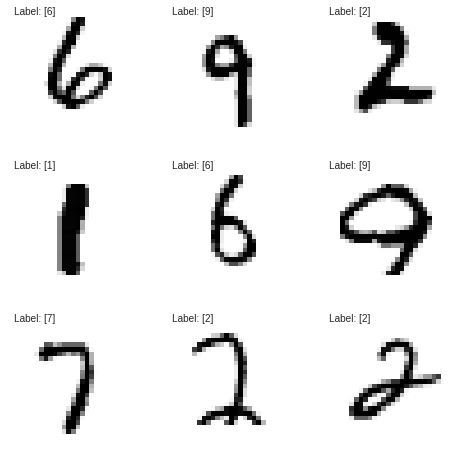

In [139]:
# Check a few training values at random as a sanity check
def show_label_images(X, y, images=None):
    '''Shows random images in a grid
    INPUT: X - image data
           y - class label
           images - indexes of images to show. Randomly selected if None
    RETURNS: Nothing.
    '''
    
    num = 3
    num_square = num ** 2
    
    if images is None:
        images = np.random.randint(0, X.shape[0], num_square)
        
    print('Showing training image indexes {}'.format(images))

    fig, axes = plt.subplots(num,num, figsize=(8,8))
    for idx, val in enumerate(images):
        r, c = divmod(idx, num)
        ax = axes[r][c]
        ax.imshow(X[images[idx]]) # , cmap=plt.cm.binary)
        ax.annotate('Label: {}'.format(y[val]), xy=(1, 1))
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

show_label_images(square_images(X_train, 28, 28), y_train)


### Image resizing functions


In [ ]:
from PIL import Image
from tqdm import *

def resize_image(image, img_size, back_size, back_color):
    '''Resizes the image to `new_size`, pastes in center of backgrond
    INPUT: image = Input image
           img_size = tuple of images new dimensions
           back_size = tuple of new image background dimensions
           back_color = color to fill background with
    RETURNS: New image
    '''

    new_img = Image.new('L', back_size, (back_color,))
    img = Image.fromarray(image)
    img.thumbnail(img_size, Image.ANTIALIAS) 

    h_diff = int((back_size[0] - img_size[1]) / 2)
    w_diff = int((back_size[1] - img_size[1]) / 2)

    new_img.paste(img, (h_diff, w_diff))
    return np.asarray(new_img)

def resize_image_array(X, img_size, back_size, back_color, desc=None):
    '''Resizes images held in a numpy array'''
    X_out = np.zeros_like(X)
    n_images = X.shape[0]
    for idx in tqdm(range(n_images), desc=desc): # "Resizing {} images".format(n_images)):
        X_out[idx] = resize_image(X[idx], img_size, back_size, 0)
        
    return X_out

X_train_resize = resize_image_array(X_train_input, (20,20), (28,28), 0, 'Resizing training images')
X_test_resize = resize_image_array(X_test_input, (20,20), (28,28), 0, 'Resizing training images')

# Reshape the images so they're a single row in the numpy array
X_train_resize = X_train_resize_float.reshape((n_train, w * h))
X_test_resize = X_test_resize_float.reshape((n_test, w * h))


print('Z-normalizing X data')
std = StandardScaler()
X_train_resize_float = X_train_resize.astype(np.float32)
X_test_resize_float = X_test_resize.astype(np.float32)



std.fit(X_train_resize_float.astype(np.float32))
X_train = std.transform(X_train_resize_float)
X_test = std.transform(X_test_resize_float)





In [ ]:
print(w, h)

In [ ]:
# Model a - 28x28-300-10: 4.7% Error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(300, input_dim=784))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))
print('Model summary:\n')
model.summary()

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

print('\nTraining model\n')
model.fit(X_train, y_train,
          nb_epoch=NB_EPOCH,
          batch_size=BATCH,
          verbose=2)

print('\nGenerating predictions on test set\n')
scores = model.evaluate(X_test, y_test, batch_size=BATCH)
errors = [1.0 - score for score in scores]

print('\n\nTest set training error {:.4f}, test error {:.4f}'.format(errors[0], errors[1]))

In [ ]:
model.summary()

## 